# Packages and functions

In [167]:
import numpy as np
from random import random
from random import randint
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
import pandas as pd
import numpy as np
from time import time
from gensim.models import Word2Vec
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from scipy.sparse import identity, diags
from urllib.request import urlopen
import torch.nn.functional as F
from sklearn.metrics import log_loss, accuracy_score
import re
from gensim.parsing.preprocessing import remove_stopwords
from random import choice



!pip install unidecode

from unidecode import unidecode

#from nltk.stem import WordNetLemmatizer
#lemmatizer = WordNetLemmatizer()

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")



zsh:1: command not found: pip


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ghassenabdedayem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Subsection to generate goog300 mean embedding

In [11]:
from tqdm.notebook import tqdm
def list_words_to_one_sentence_wv_vector(sentences_list_words, wv_model):
    t = time()

    embedded_abstracts = dict()
    for node, abstract in tqdm(enumerate(sentences_list_words)):
        #some abstracts are null
        cleaned_abstract=[]
        for word in abstract:
            try: 
                wv_model[word] #we try to find the word in the Vocabulary
                cleaned_abstract.append(word)
            except: pass
        if len(cleaned_abstract) > 0:
            wv_model[cleaned_abstract]
            embedded_abstracts[node] = np.mean(wv_model[cleaned_abstract], axis=0)
        # for quartile in np.percentile(wv_model.wv[abstract], [25, 50, 75], axis=0):
        #     embedded_abstracts[node] = np.concatenate((embedded_abstracts[node], quartile), axis=0)
        else: #if the abstract text is null, we fill the embedded text vector by random numbers (it could help to prevent overfittiing)
            embedded_abstracts[node] = np.random.uniform(wv_model.vectors.min(), wv_model.vectors.max(), size=embedded_abstracts[0].shape)
    print('nodes embeddings generated based on words embeddings in {:.0f} sec in embedded_abstracts'.format(time()-t)) #206 sec
    return embedded_abstracts

In [23]:
#import urllib.request
import pickle

url = 'https://storage.googleapis.com/link_prediction_processed_data/vocab.pkl'

# Download the vocabulary from the URL
with urllib.request.urlopen(url) as response:
     data = response.read()

    
# Load the vocabulary using pickle
voc = pickle.loads(data)

In [26]:


##### NEW with GOOG vocab --> to test
import gensim.downloader as api
print('downloading word2vec google news 300...')
t = time()
wv_model = api.load('word2vec-google-news-300')
print('Model downloaded in {} s'.format(round(time()-t)))








downloading word2vec google news 300...
Model downloaded in 43 s


0it [00:00, ?it/s]

nodes embeddings generated based on words embeddings in 3127 sec in embedded_abstracts


NameError: name 'embedded_abstracts_array' is not defined

In [40]:
embedded_abstracts = list_words_to_one_sentence_wv_vector(voc.sentences_list_words, wv_model)

embedded_abstracts_array = np.array(list(embedded_abstracts.values()))



In [41]:


filename = "embedded_abstracts_goog300.npy"
# Save the compressed file
np.save(filename, embedded_abstracts_array)

In [42]:
loaded_file_array = np.load(filename)
loaded_file_array.shape, embedded_abstracts_array.shape

((138499, 300), (138499, 300))

In [2]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [54]:

def text_to_list(text): # a function that split the text of the authors to a list of authors
    return unidecode(text).split(',')

def intersection(lst1, lst2): # a function that returns the number of common items of two lists and 1 or 0 if there are common. This function will be used in add_authors_to_pairs to add this features to the pairs.
    lst3 = [value for value in lst1 if value in lst2]
    is_common = 1 if len(lst3)>0 else 0
    return len(lst3), is_common


def save_subgraph_in_file(nbr_nodes, source_path='../input_data/edgelist.txt', destination_path='../input_data/small_edgelist.txt'):
    G = nx.read_edgelist(source_path, delimiter=',', create_using=nx.Graph(), nodetype=int)
    G = G.subgraph(range(nbr_nodes))
    nx.write_edgelist(G, path=destination_path, delimiter=',')
    print(G.number_of_nodes(), 'nodes,', G.number_of_edges(), 'edges Graph extracted from', source_path[source_path.rfind('/')+1:])
    G = nx.read_edgelist(destination_path, delimiter=',', create_using=nx.Graph(), nodetype=int)
    print(G.number_of_nodes(), 'nodes,', G.number_of_edges(), 'edges Graph saved in', destination_path[destination_path.rfind('/')+1:])
    print(max(G.nodes))
    return


def read_train_val_graph(path='small_edgelist.txt', val_ratio=0.1):
    #gets the data from the file on the distant server
    G = nx.read_edgelist(urlopen('https://www.lix.polytechnique.fr/~nikolentzos/files/aai/challenge/edgelist.txt'), delimiter=',', create_using=nx.Graph(), nodetype=int)
    #G = nx.read_edgelist(path, delimiter=',', create_using=nx.Graph(), nodetype=int)
    nodes = list(G.nodes())
    n = G.number_of_nodes()
    m = G.number_of_edges()
    edges = list(G.edges())

    print('Number of nodes:', n, 'number of edges:', m,'in the Complete the set')

    node_to_idx = dict()
    for i, node in enumerate(nodes):
        node_to_idx[node] = i

    val_edges = list()
    G_train = G.copy()

    for edge in edges:
        if random() < val_ratio and edge[0] < n and edge[1] < n:
            val_edges.append(edge)
            G_train.remove_edge(edge[0], edge[1]) # We remove the val edges from the graph G

   
    #for edge in val_edges:
        

    n = G_train.number_of_nodes()
    m = G_train.number_of_edges()
    train_edges = list(G_train.edges())

    print('Number of nodes:', n, 'number of edges:', m, 'in the Training set')
    print('len(nodes)', len(nodes))

    y_val = [1]*len(val_edges)

    n_val_edges = len(val_edges)
    
    print('Creating random val_edges...')
    for i in range(n_val_edges):
        n1 = nodes[randint(0, n-1)]
        n2 = nodes[randint(0, n-1)]
        (n1, n2) = (min(n1, n2), max(n1, n2))
        while n2 >= n: #or (n1, n2) in train_edges:
            if (n1, n2) in train_edges:
                print((n1, n2), 'in train_edges:')
            n1 = nodes[randint(0, n-1)]
            n2 = nodes[randint(0, n-1)]
            (n1, n2) = (min(n1, n2), max(n1, n2))
        val_edges.append((n1, n2))

    y_val.extend([0]*(n_val_edges))
    
    ### From Giannis /!\
    val_indices = np.zeros((2,len(val_edges)))
    for i,edge in enumerate(val_edges):
        val_indices[0,i] = node_to_idx[edge[0]]
        val_indices[1,i] = node_to_idx[edge[1]]
    
    print('Returned G_train, train_edges, val_edges, y_val, nodes and node_to_idx objects')
    print('Loaded from', path[path.rfind('/')+1:], 'and with a training validation split ratio =', val_ratio)
    
    
    
    return G, G_train, train_edges, val_edges, val_indices, y_val, nodes, node_to_idx

def random_walk(G, node, walk_length):
    walk = [node]
  
    for i in range(walk_length-1):
        neibor_nodes = list(G.neighbors(walk[-1]))
        if len(neibor_nodes) > 0:
            next_node = choice(neibor_nodes)
            walk.append(next_node)
    walk = [node for node in walk] # in case the nodes are in string format, we don't need to cast into string, but if the nodes are in numeric or integer, we need this line to cast into string
    return walk


def generate_walks(G, num_walks, walk_length):
  # Runs "num_walks" random walks from each node, and returns a list of all random walk
    t = time()
    print('Start generating walks....')
    walks = list()  
    for i in range(num_walks):
        for node in G.nodes():
            walk = random_walk(G, node, walk_length)
            walks.append(walk)
        #print('walks : ', walks)
    print('Random walks generated in in {}s!'.format(round(time()-t)))
    return walks

def apply_word2vec_on_features(features, nodes, vector_size=128, window=5, min_count=0, sg=1, workers=8):
    t = time()
    print('Start applying Word2Vec...')
    wv_model = Word2Vec(vector_size=vector_size, window=window, min_count=min_count, sg=sg, workers=workers)
    wv_model.build_vocab(features)
    wv_model.train(features, total_examples=wv_model.corpus_count, epochs=5) 
    print('Word2vec model trained on features in {} min!'.format(round((time()-t)/60)))
    features_np = []
    for node in nodes:
        features_np.append(wv_model.wv[node])

    features_np = np.array(features_np)
    print(features_np.shape, 'features numpy array created in {} min!'.format(round((time()-t)/60)))
    return features_np



def normalize_adjacency(A):
    n = A.shape[0]
    A = A + identity(n)
    degs = A.dot(np.ones(n))
    inv_degs = np.power(degs, -1)
    D_inv = diags(inv_degs)
    A_hat = D_inv.dot(A)
    return A_hat

def create_and_normalize_adjacency(G):
    adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix of the training graph
    adj = normalize_adjacency(adj)
    print('Created a normalized adjancency matrix of shape', adj.shape)
    indices = np.array(adj.nonzero()) # Gets the positions of non zeros of adj into indices
    print('Created indices', indices.shape, 'with the positions of non zeros in adj matrix')
    return adj, indices

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)
 

def add_authors_to_pairs (pairs, authors):
    #authors = pd.DataFrame(authors)
    try: 
        pairs = pairs.detach().cpu().numpy()
    except:
        pass

    pairs_df = pd.DataFrame(np.transpose(pairs)).rename(columns={0: "paper_1", 1: "paper_2"})
    #pairs = torch.tensor(pairs).to(device)
    pairs_df = pairs_df.merge(authors, left_on='paper_1', right_on='paper_id', how='left').rename(columns={'authors': "authors_1"})
    pairs_df = pairs_df.merge(authors, left_on='paper_2', right_on='paper_id', how='left').rename(columns={'authors': "authors_2"})
    pairs_df.drop(['paper_id_x', 'paper_id_y'], axis=1, inplace=True)

    pairs_df['nb_common_author'] = pairs_df.apply(lambda row: intersection(row['authors_1'], row['authors_2'])[0], axis=1)
    pairs_df['is_common_author'] = pairs_df.apply(lambda row: intersection(row['authors_1'], row['authors_2'])[1], axis=1)

    #pairs_tensor = torch.LongTensor(np.transpose(pairs_df[["paper_1", "paper_2", 'is_common_author', 'nb_common_author']].values.tolist())).to(device)
    
    return np.transpose(pairs_df[["paper_1", "paper_2", 'is_common_author', 'nb_common_author']].values.tolist())




In [19]:
def read_and_clean_abstracts (nodes, sample_length=-1, abstracts_path = 'https://www.lix.polytechnique.fr/~nikolentzos/files/aai/challenge/abstracts.txt'):
    t = time()
    abstracts = dict()
    abstracts_list = list()
    f = urlopen(abstracts_path)
    
    for i, line in enumerate(f):
        if i == sample_length:
            break
        if i in nodes:
            node, abstract = str(line).lower().split('|--|')
            abstract = remove_stopwords(abstract)
            #abstract = re.sub(r"[,.;@#?!&$()-]", " ", abstract)
            abstract = re.sub(r"[^a-zA-Z0-9\s]", "", abstract)
            #abstract = re.sub(r"\\", " ", abstract)
            abstract = remove_stopwords(abstract)

            for word in abstract.split()[:-1]:
                #abstract = abstract.replace(word, stemmer.stem(word))
                abstract = abstract.replace(word, lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(word), pos='s'), pos='a'), pos='n'), pos='v'), pos='r'))
            
            node = re.sub("[^0-9]", "", node)
            if i != int(node):
                print('i and node not the same', i, node)
            abstracts[int(node)] = abstract
            abstracts_list.append(abstract)
        
    print('Text loaded and cleaned in {:.0f} min'.format((time()-t)/60))
    return abstracts

def doc_counter (documents, word): #a function that return the number of documents containing a word
    counter = 0
    for i in documents:
        if word in documents[i]:
            counter += 1
    return counter


In [185]:
class Vocabulary:

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.word_occurrence = {}
        self.words_list = []
        self.sentences_list = []
        self.sentences_list_words = []
        self.num_words = 0
        self.num_sentences = 0
        self.longest_sentence = 0

    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.words_list.append(word)
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
            self.word_occurrence[word] = 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            self.word_occurrence[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        max_length = 128
        for i, word in enumerate(sentence.split()[:-1]):
            sentence_len += 1
            self.add_word(word)
            if sentence_len == max_length:
                break
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1
        self.sentences_list.append(sentence)
        self.sentences_list_words.append(sentence.split()[:-1])

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

    def words(self):
        return self.words_list



In [6]:
def list_words_to_one_sentence_wv_vector(wv_model, sentences_list_words):
    t = time()

    embedded_abstracts = dict()
    for node, abstract in enumerate(sentences_list_words):
        #some abstracts are null
        cleaned_abstract=[]
        for word in abstract:
            try: 
                wv_model[word] #we try to find the word in the Vocabulary
                cleaned_abstract.append(word)
            except: pass
        if len(cleaned_abstract) > 0:
            wv_model[cleaned_abstract]
            embedded_abstracts[node] = np.mean(wv_model[cleaned_abstract], axis=0)
            for quartile in np.percentile(wv_model[cleaned_abstract], [25, 50, 75], axis=0):
                embedded_abstracts[node] = np.concatenate((embedded_abstracts[node], quartile), axis=0)
        else: #if the abstract text is null, we fill the embedded text vector by random numbers (it could help to prevent overfittiing)
            embedded_abstracts[node] = np.random.uniform(wv_model.vectors.min(), wv_model.vectors.max(), size=embedded_abstracts[0].shape)
        if (node % 100 == 0):
            print('Procssed at {:.0f} % in {:.0f} min'.format((node / len(abstracts))*100, (time()-t)/60))
    print('nodes embeddings generated based on words embeddings in {:.0f} min'.format((time()-t)/60)) #206 sec
    return embedded_abstracts, cleaned_abstract

In [7]:
def word_embeddings_replace_missing_words_with_random(wv_model, abstracts):
    t = time()
    embedded_abstracts = dict()
    
    for node, abstract_list_of_words in enumerate(abstracts):
        if len(abstract_list_of_words) == 0:
            embedded_abstracts[node] = []
        else:
            missing_word_mask = ~np.isin(abstract_list_of_words, wv_model.index_to_key)
            missing_word_indices = np.where(missing_word_mask)[0]
            missing_word_embeddings = np.random.rand(len(missing_word_indices), wv_model.vector_size)
            abstract_list_of_words_clean = np.compress(~missing_word_mask, abstract_list_of_words)
            result_embeddings = np.vstack((wv_model[abstract_list_of_words_clean], missing_word_embeddings))
            embedded_abstracts[node] = result_embeddings
        if (node % 10 == 0):
            print('Procssed at {:.0f} % in {:.0f} min'.format((node / len(abstracts))*100, (time()-t)/60))
    print('list of words embeddings generated for each node in {:.0f} min'.format((time()-t)/60))
    return embedded_abstracts



In [8]:
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

def replace_missing_words_with_random(abstract_list_of_words, wv_model):
    if len(abstract_list_of_words) == 0:
        embedded_abstracts[node] = []
    else:
        missing_word_mask = ~np.isin(abstract_list_of_words, wv_model.index_to_key)
        missing_word_indices = np.where(missing_word_mask)[0]
        missing_word_embeddings = np.random.rand(len(missing_word_indices), wv_model.vector_size)
        abstract_list_of_words_clean = np.compress(~missing_word_mask, abstract_list_of_words)
        result_embeddings = np.vstack((wv_model[abstract_list_of_words_clean], missing_word_embeddings))
    return result_embeddings

def word_embeddings_replace_missing_words_with_random(wv_model, abstracts):
    t = time()
    embedded_abstracts = dict()
    
    with Pool(processes=cpu_count()) as p:
        results = list(tqdm(p.imap(lambda x: replace_missing_words_with_random(x, wv_model), abstracts), total=len(abstracts)))
    
    for node, result_embeddings in enumerate(results):
        embedded_abstracts[node] = result_embeddings
    
    print('list of words embeddings generated for each node in {:.0f} min'.format((time()-t)/60))
    return embedded_abstracts

In [9]:
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial

def replace_missing_words_with_random(abstract_list_of_words, wv_model):
    if len(abstract_list_of_words) == 0:
        embedded_abstracts[node] = []
    else:
        missing_word_mask = ~np.isin(abstract_list_of_words, wv_model.index_to_key)
        missing_word_indices = np.where(missing_word_mask)[0]
        missing_word_embeddings = np.random.rand(len(missing_word_indices), wv_model.vector_size)
        abstract_list_of_words_clean = np.compress(~missing_word_mask, abstract_list_of_words)
        result_embeddings = np.vstack((wv_model[abstract_list_of_words_clean], missing_word_embeddings))
    return result_embeddings

def word_embeddings_replace_missing_words_with_random(wv_model, abstracts):
    t = time()
    embedded_abstracts = dict()
    
    with Pool(processes=cpu_count()) as p:
        results = list(tqdm(p.imap(partial(replace_missing_words_with_random, wv_model=wv_model), abstracts), total=len(abstracts)))
        
    for node, result_embeddings in enumerate(results):
        embedded_abstracts[node] = result_embeddings
        
    print('list of words embeddings generated for each node in {:.0f} min'.format((time()-t)/60))
    return embedded_abstracts

In [10]:
def list_words_to_one_sentence_wv_vector(wv_model, sentences_list_words):
    t = time()

    embedded_abstracts = dict()
    for node, abstract in enumerate(sentences_list_words):
        #some abstracts are null
        cleaned_abstract=[]
        for word in abstract:
            try: 
                wv_model[word] #we try to find the word in the Vocabulary
                cleaned_abstract.append(word)
            except: pass
        if len(cleaned_abstract) > 0:
            wv_model[cleaned_abstract]
            embedded_abstracts[node] = np.mean(wv_model[cleaned_abstract], axis=0)
            for quartile in np.percentile(wv_model[cleaned_abstract], [25, 50, 75], axis=0):
                embedded_abstracts[node] = np.concatenate((embedded_abstracts[node], quartile), axis=0)
        else: #if the abstract text is null, we fill the embedded text vector by random numbers (it could help to prevent overfittiing)
            embedded_abstracts[node] = np.random.uniform(wv_model.vectors.min(), wv_model.vectors.max(), size=embedded_abstracts[0].shape)
        if (node % 10000 == 0):
            print('Procssed at {:.0f} % in {:.0f} min'.format((node / len(abstracts))*100, (time()-t)/60))
    print('nodes embeddings generated based on words embeddings in {:.0f}'.format((time()-t)/60)) #206 sec
    return embedded_abstracts, cleaned_abstract

In [11]:
def list_words_to_list_embeddings(sentences_list_words, wv_model):
    t = time()

    embedded_abstracts = dict()
    for node, abstract in enumerate(sentences_list_words):
        #some abstracts are null
        cleaned_abstract=[]
        for word in abstract:
            try: 
                wv_model[word] #we try to find the word in the Vocabulary
                cleaned_abstract.append(word)
            except: pass
        if len(cleaned_abstract) > 0:
            embedded_abstracts[node] = wv_model[cleaned_abstract]
        else: #if the abstract text is null, we fill the embedded text vector by random numbers (it could help to prevent overfittiing)
            embedded_abstracts[node] = np.zeros(shape=embedded_abstracts[0].shape)
        if (node % 10000 == 0):
            print('Procssed at {:.0f} % in {:.0f} min'.format((node / len(abstracts))*100, (time()-t)/60))
    print('nodes embeddings generated based on words embeddings in {:.0f} min in embedded_abstracts'.format((time()-t)/60)) #206 sec
    return embedded_abstracts, cleaned_abstract

In [44]:
def train_wv_on_vocab (voc, vector_size):
    t = time()
    wv_model = Word2Vec(vector_size=vector_size, window=5, min_count=1, sg=1, workers=8)
    wv_model.build_vocab(voc.sentences_list_words)
    wv_model.train(voc.sentences_list_words, total_examples=wv_model.corpus_count, epochs=5) 
    print('word2vec trained in {:.0f} sec'.format(time()-t)) #219 sec
    return wv_model



# Features processing

In [168]:
path = 'input_data/edgelist.txt' #not used

G, G_train, train_edges, val_edges, val_indices, y_val, nodes, node_to_idx = read_train_val_graph(path=path, val_ratio=0.1)


Number of nodes: 138499 number of edges: 1091955 in the Complete the set
Number of nodes: 138499 number of edges: 982568 in the Training set
len(nodes) 138499
Creating random val_edges...
Returned G_train, train_edges, val_edges, y_val, nodes and node_to_idx objects
Loaded from edgelist.txt and with a training validation split ratio = 0.1


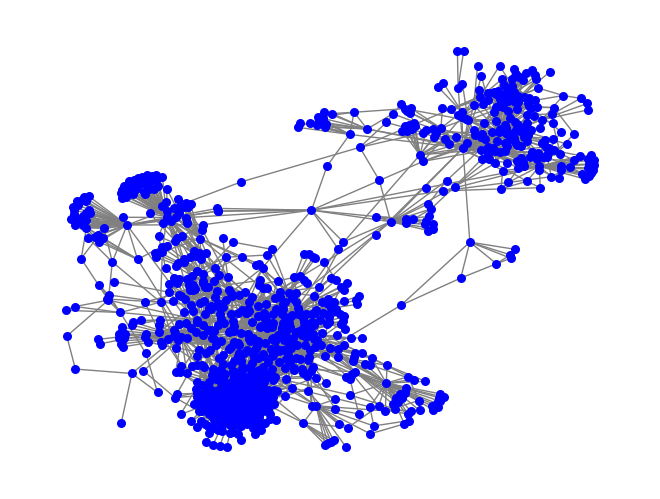

In [148]:
import matplotlib.pyplot as plt

# create a NetworkX graph
sub_G = G.subgraph(list(G.nodes())[0:1000])


# draw the graph
nx.draw(sub_G, with_labels=False, node_color='blue', node_size=30, edge_color='gray')

# show the graph
plt.show()

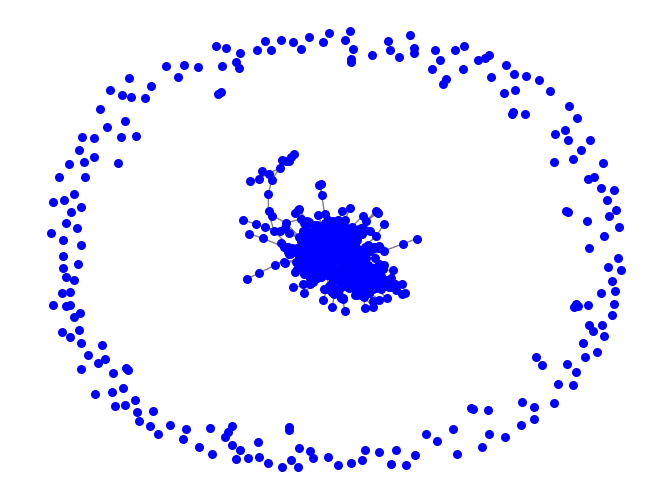

In [150]:
import matplotlib.pyplot as plt

# create a NetworkX graph
sub_G = G.subgraph(list(G.nodes())[1000:2000])


# draw the graph
nx.draw(sub_G, with_labels=False, node_color='blue', node_size=30, edge_color='gray')

# show the graph
plt.show()

In [109]:
import random

sub_edges = []
random_sub_edges = []
num_nodes = G.number_of_nodes()
permutation = random.sample(range(num_nodes), num_nodes)

for i in range(num_nodes, 20000):
    sub_nodes = permutation[i:i+20000]
    sub_edges.append(G.subgraph(sub_nodes).number_of_edges())
    random_sub_nodes = random.sample(G.nodes(), 2000)
    random_sub_edges.append(G.subgraph(random_sub_nodes).number_of_edges())

In [ ]:
# create a subgraph
sub = G.subgraph([1,2,3])

# get the isolated nodes in the subgraph
isolated_nodes = list(nx.isolates(sub))

# count the number of isolated nodes
num_isolated = len(isolated_nodes)

In [151]:
sub_edges = []
num_isolated = []
random_sub_edges = []
random_num_isolated = []
size_of_subset = 10000

# generate a permutation of node indices
perm = np.random.permutation(G.number_of_nodes())

# loop over permutations of size_of_subset nodes
for i in tqdm(range(0, G.number_of_nodes(), size_of_subset)):
    nodes = list(range(i, i+size_of_subset))
    subgraph = G.subgraph(nodes)
    sub_edges.append(subgraph.number_of_edges())
    num_isolated.append(len(list(nx.isolates(subgraph))))
    
    # generate a random selection of size_of_subset nodes
    random_nodes = perm[i:i+size_of_subset]
    random_subgraph = G.subgraph(random_nodes)
    random_sub_edges.append(random_subgraph.number_of_edges())
    random_num_isolated.append(len(list(nx.isolates(random_subgraph))))


  0%|          | 0/14 [00:00<?, ?it/s]

In [176]:
# empty_abstracts = 0
# long_abstracts = []
# very_long_abstracts = []
# huge_abstracts = []
# for i, sentence in tqdm(enumerate(voc2.sentences_list_words)):
#     if len(sentence) == 0:
#         empty_abstracts += 1
#     if len(sentence) > 128:
#         long_abstracts.append(i)
#     if len(sentence) > 256:
#         very_long_abstracts.append(i)
#     if len(sentence) > 512:
#         huge_abstracts.append(i)
# print(empty_abstracts, len(long_abstracts), len(very_long_abstracts), len(huge_abstracts))


0it [00:00, ?it/s]

7249 82394 4171 65


In [153]:
print(sub_edges)
print(random_sub_edges)
print(num_isolated)
print(random_num_isolated)


[56226, 58756, 38085, 35383, 29300, 21488, 16846, 10622, 7739, 7984, 27856, 8038, 5133, 1510]
[5700, 5778, 5415, 6307, 5534, 5809, 5690, 5577, 5927, 5550, 5465, 5382, 5802, 4074]
[47, 172, 712, 680, 1294, 1956, 2253, 3228, 4044, 4165, 3179, 3707, 4494, 6278]
[5031, 4939, 5079, 4947, 4974, 5002, 5043, 5095, 4969, 5060, 5149, 5189, 4910, 4586]


In [123]:
print(sub_edges)
print(random_sub_edges)

[5687, 5691, 5369, 5719, 5250, 6281, 5730, 5730, 5879, 5813, 5831, 5548, 5721, 3956]
[6009, 5543, 5371, 5914, 5346, 5897, 5773, 5990, 5656, 5722, 5489, 5758, 5149, 5389]


In [15]:
num_walks = 10
walk_length=15
wv_vector_size = 64

walks = generate_walks(G=G_train, num_walks=num_walks, walk_length=walk_length)
walks_wv = apply_word2vec_on_features(features=walks, nodes=nodes, vector_size=wv_vector_size)
adj, indices = create_and_normalize_adjacency(G_train)



Number of nodes: 138499 number of edges: 1091955 in the Complete the set
Number of nodes: 138499 number of edges: 982862 in the Training set
len(nodes) 138499
Creating random val_edges...
Returned G_train, train_edges, val_edges, y_val, nodes and node_to_idx objects
Loaded from small_edgelist.txt and with a training validation split ratio = 0.1
Start generating walks....
Random walks generated in in 57s!
Start applying Word2Vec...
Word2vec model trained on features in 2 min!
(138499, 64) features numpy array created in 2 min!


/var/folders/pd/glcnl2497w5b6xn3p94tnwlr0000gn/T/ipykernel_94609/975224092.py:139: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix of the training graph


Created a normalized adjancency matrix of shape (138499, 138499)
Created indices (2, 2104223) with the positions of non zeros in adj matrix


In [177]:
def read_and_clean_abstracts (nodes, sample_length=-1, abstracts_path = 'https://www.lix.polytechnique.fr/~nikolentzos/files/aai/challenge/abstracts.txt'):
    t = time()
    abstracts = dict()
    abstracts_list = list()
    f = urlopen(abstracts_path)
    
    for i, line in tqdm(enumerate(f)):
        if i == sample_length:
            break
        if i in nodes:
            node, abstract = str(line).lower().split('|--|')
            abstract = remove_stopwords(abstract)
            #abstract = re.sub(r"[,.;@#?!&$()-]", " ", abstract)
            abstract = re.sub(r"[^a-zA-Z0-9\s]", "", abstract)
            #abstract = re.sub(r"\\", " ", abstract)
            abstract = remove_stopwords(abstract)

            for word in abstract.split()[:-1]:
                #abstract = abstract.replace(word, stemmer.stem(word))
                abstract = abstract.replace(word, lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(word), pos='s'), pos='a'), pos='n'), pos='v'), pos='r'))
            
            node = re.sub("[^0-9]", "", node)
            if i != int(node):
                print('i and node not the same', i, node)
            abstracts[int(node)] = abstract
            abstracts_list.append(abstract)
        
    print('Text loaded and cleaned in {:.0f} min'.format((time()-t)/60))
    return abstracts

def doc_counter (documents, word): #a function that return the number of documents containing a word
    counter = 0
    for i in documents:
        if word in documents[i]:
            counter += 1
    return counter


In [178]:

n = -1 #length of the sample to develop and test the pipeline (-1 or negative values to take all the dataset)

#takes 4 minutes to process all the abstracts
abstracts = read_and_clean_abstracts(nodes, sample_length=n)  #149s #194s
abstracts_dict_list_words = {i: abstracts[i].split()[:-1] for i in nodes}
abstracts_list_sentences = [list(item)[1][:-3] for item in abstracts.items()]

#we create a vacabulary of words and sentences (abstracts)
#we take only a sample of 3 abstracts (i=2) to explore the approach
t = time()
voc = Vocabulary('abstracts') 
for i in tqdm(nodes):
    voc.add_sentence(abstracts[i])

print('Vocab built in {:.0f} min'.format((time()-t)/60))

0it [00:00, ?it/s]

Text loaded and cleaned in 7 min


  0%|          | 0/138499 [00:00<?, ?it/s]

Vocab built in 0 min


In [190]:
t = time()
trunc_voc = Vocabulary('abstracts') 
for i in tqdm(nodes):
    trunc_voc.add_sentence(abstracts[i])

print('Vocab built in {:.0f} min'.format((time()-t)/60))

  0%|          | 0/138499 [00:00<?, ?it/s]

Vocab built in 0 min


In [202]:
#apply wv to abstracts
t = time()
vector_size = 300

wv_model = train_wv_on_vocab (trunc_voc, vector_size=vector_size)
print('Word2vec model trained on abstracts in {:.0f} min'.format((time()-t)/60))

word2vec trained in 109 sec
Word2vec model trained on abstracts in 2 min


In [203]:
len(wv_model.wv.key_to_index), trunc_voc.num_words

(188891, 183673)

In [1]:
# Load 192 abstract words embeddings

url = 'https://storage.googleapis.com/link_prediction_processed_data/embedded_abstracts_dict_192array.pkl.gz'

import requests
import gzip
import pickle


response = requests.get(url)
compressed_data = response.content

data = gzip.decompress(compressed_data)
words_embedding_192 = pickle.loads(data)

len(words_embedding_192)

KeyboardInterrupt: 

In [ ]:
words_embedding_192_trunc128 = dict ()
for i in tqdm(range(len(words_embedding_192))):
    if len(words_embedding_192[i])>0:
        arr = np.zeros((128, 192))
        vec = words_embedding_192[i][:128, :]
        arr[:vec.shape[0],:] = vec
        words_embedding_192_trunc128[i] = arr
    else:
        words_embedding_192_trunc128[i] = []

In [179]:
empty_abstracts = 0
long_abstracts = []
very_long_abstracts = []
huge_abstracts = []
for i, sentence in tqdm(enumerate(voc.sentences_list_words)):
    if len(sentence) == 0:
        empty_abstracts += 1
    if len(sentence) > 128:
        long_abstracts.append(i)
    if len(sentence) > 256:
        very_long_abstracts.append(i)
    if len(sentence) > 512:
        huge_abstracts.append(i)
print(empty_abstracts, len(long_abstracts), len(very_long_abstracts), len(huge_abstracts))
print(voc.longest_sentence)

0it [00:00, ?it/s]

7249 11217 95 12
915


In [184]:
voc.num_words

188891

In [50]:
wv_model = wv_model.wv

In [51]:
embedded_abstracts = list_words_to_one_sentence_wv_vector(voc.sentences_list_words, wv_model)

embedded_abstracts_array = np.array(list(embedded_abstracts.values()))

filename = "embedded_abstracts_local_wv300.npy"
# Save the compressed file
np.save(filename, embedded_abstracts_array)

0it [00:00, ?it/s]

nodes embeddings generated based on words embeddings in 251 sec in embedded_abstracts


In [22]:
#apply wv to abstracts
t = time()
vector_size = 300

wv_model = train_wv_on_vocab (voc, vector_size=vector_size)
print('Word2vec model trained on abstracts in {:.0f} min'.format((time()-t)/60))


word2vec trained in 121 sec
Word2vec model trained on abstracts in 2 min


In [31]:
voc.word2count['max\\xe2\\x80\\x89\\xe2\\x80\\x93min\\xe2\\x80\\x89']

4

In [28]:
wv_model.wv.most_similar('max\\xe2\\x80\\x89\\xe2\\x80\\x93min\\xe2\\x80\\x89')

[('snsg', 0.8850984573364258),
 ('expoe', 0.8813768029212952),
 ('asigning', 0.8781048059463501),
 ('constituencybase', 0.8754180073738098),
 ('syntactico', 0.8732102513313293),
 ('dnv', 0.8728715181350708),
 ('vssp', 0.8714112043380737),
 ('subcategorisations', 0.8712791204452515),
 ('cvg', 0.8703361749649048),
 ('discourse:', 0.8703027367591858)]

In [40]:
del (words_embeddings_multithread_3)
import warnings
warnings.filterwarnings("ignore")
from my_functions import words_embeddings_multithread_3

list_embeddings = words_embeddings_multithread_3(wv_model.wv, voc.sentences_list_words)

100%|████████████████████████████████| 138499/138499 [15:04:21<00:00,  2.55it/s]


list of words embeddings generated for each node in 904 min


In [77]:
import gzip
import pickle


# Compress the data
compressed_data = gzip.compress(pickle.dumps(list_embeddings))

# Write compressed data to a file
with open('my_file.pkl.gz', 'wb') as f:
    f.write(compressed_data)

In [ ]:
with open('my_file.pkl.gz', 'rb') as f:
    compressed_data = f.read()

# Decompress the data
compressed_data = pickle.loads(gzip.decompress(compressed_data))
len(compressed_data)

In [41]:
np.save('embedded_abstracts_list_array.npy', list_embeddings)
print('abstracts words embeddings npy saved in file')


abstracts words embeddings npy saved in file


In [63]:
authors = pd.read_csv(urlopen('https://linkpredictionproject.s3.eu-west-3.amazonaws.com/input_data/authors.txt'), sep = '|', header=None)
authors = authors.rename(columns={0: "paper_id", 2: "authors"})
#authors = authors[authors['paper_id'].isin(nodes) ]
authors['authors'] = authors['authors'].apply(text_to_list)
authors = authors[["paper_id", "authors"]]
authors = authors[authors['paper_id'] <= max(G.nodes())]
authors.head()

,paper_id,authors
0,0,"[James H. Niblock, Jian-Xun Peng, Karen R. McM..."
1,1,"[Jian-Xun Peng, Kang Li, De-Shuang Huang]"
2,2,[J. Heikkila]
3,3,"[L. Teslic, B. Hartmann, O. Nelles, I. Skrjanc]"
4,4,"[Long Zhang, Kang Li, Er-Wei Bai, George W. Ir..."


In [71]:
# HERE WE CONCATENATE THE WALKS FEATURES AND THE ABSTRACTS FEATURES
#features_np = np.concatenate((walks_wv, embedded_abstracts), axis=1)
features_np = walks_wv

In [69]:
def random_subset_with_mc_sampling(lst, ratio):
    weights = np.ones(np.shape(lst)[1]) / np.shape(lst)[1]  # Uniform distribution
    indices = np.random.choice(np.shape(lst)[1], size=round(ratio*np.shape(lst)[1]), replace=False, p=weights)
    return lst[:, indices]


In [70]:
t = time()
indices_mc = random_subset_with_mc_sampling(indices, ratio = 0.1)
#indices_mc = indices # without mc sampling
indices_mc = add_authors_to_pairs(indices_mc, authors)

#### we put this part inside the training to avoid overfitting
# rand_indices = np.random.randint(0, len(indices_mc), size=(indices_mc.shape[0], indices_mc.shape[1]))
# rand_indices = add_authors_to_pairs(rand_indices, authors)

# pairs = np.concatenate((indices_mc, rand_indices), axis=1)

val_indices = add_authors_to_pairs(val_indices, authors)
print ('Finished sampling and authors added to pairs in {:.0f} sec'.format(time()-t))

Finished sampling and authors added to pairs in 40 sec


# Transform variable into tensors

In [74]:
### as we removed the creation of rand indices, we keep only indices_mc (positive edges)
#pairs_torch = torch.LongTensor(pairs).to(device)
#indices_mc_torch = torch.LongTensor(indices_mc).to(device)
val_indices_torch = torch.LongTensor(val_indices).to(device)
y_val_torch = torch.LongTensor(y_val).to(device)

# Create class labels
y = np.zeros(2*indices_mc.shape[1])
y[:indices_mc.shape[1]] = 1 # Concatenated ones for edges indices and later in the model we add zeros for random indices.
y = torch.LongTensor(y).to(device)

features_torch = torch.FloatTensor(features_np).to(device)
print('node features shape:', features_np.shape)

adj_torch = sparse_mx_to_torch_sparse_tensor(adj).to(device)
print('adj converted into a sparce torch tensor in {:.0f} sec'.format(time()-t))

node features shape: (138499, 64)
adj converted into a sparce torch tensor in 31652 sec


# Model

In [13]:
class GNN(nn.Module):
    def __init__(self, n_feat, wv_walk_size, n_hidden, n_class, sub_class, dropout):
        super(GNN, self).__init__()
        # self.fc_in = nn.Linear()
        self.fc1 = nn.Linear(n_feat, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.double_fc3 = nn.Linear((2*n_hidden+wv_walk_size), n_hidden)
        self.double_fc3 = nn.Linear((2*n_hidden), n_hidden)
        self.fc4 = nn.Linear(n_hidden, sub_class)
        self.fc5 = nn.Linear(sub_class, n_class)        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        

    def forward(self, x_in, adj, pairs, wv_walk_size):       
        
        h1 = self.fc1(x_in)
        h1 = self.relu(h1)
        h1 = self.dropout(h1)

        #h1 = self.fc2(h1)
        z1 = torch.mm(adj, h1)
        del(h1)
        z1 = self.relu(z1)
        z1 = self.dropout(z1)
        

        h2 = self.fc2(z1)
        del(z1)
        z2 = torch.mm(adj, h2)
        del(h2, adj)
        z2 = self.relu(z2)
        z2 = self.dropout(z2)
        

        x = z2[:, :wv_walk_size][pairs[0]] - z2[:, :wv_walk_size][pairs[1]] # embedded features (z2) of node 0 - embedded features of node 1 // x_in[:, :64].shape
        #x = torch.ones(size=(pairs.shape[1], wv_walk_size)).to(device)
        x = pairs[2][:, None] * x #we multiply by the number of common authors by pairs of nodes (papers) with pairs[3] || or yes/no if at least one same author (pairs[2])
        #x = x.to(device)
        x1 = z2[pairs[0]]#.to(device)
        x2 = z2[pairs[1]]#.to(device)
        del(pairs)
        #x = torch.cat((x, x1, x2), dim=1)
        x = torch.cat((x1, x2), dim=1)

        #print(np.shape(x1), np.shape(x2))
        del(x1, x2)
        
        #print(x.shape)
        x = self.relu(self.double_fc3(x))        
        x = self.dropout(x)
        
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.fc5(x)
        x = self.relu(x)
        x = self.dropout(x)

        return F.log_softmax(x, dim=1)




In [14]:
def early_stopping(loss_train, list_loss_train, loss_val, list_loss_val, 
                   tolerance=0.01, patience=15):
    list_loss_val = list(list_loss_val)[-patience:]
    list_loss_train = list(list_loss_train)[-patience:]
    if (len(list_loss_val) == patience and loss_val > (sum(list_loss_val)/len(list_loss_val)) and loss_train + tolerance < loss_val) or (len(list_loss_train) == patience and loss_train > (sum(list_loss_train)/len(list_loss_train))):
        #print('train: {:.5f} val: {:.5f} mean val: {:.5f}'.format(loss_train, loss_val, (sum(list_loss_val)/len(list_loss_val))))
        return True
    return False
    

    
def train_model(model, learning_rate, features, adj, indices_mc, y, val_indices, 
                y_val, epochs, batch_size, wv_walk_size, 
                tolerence = 0.01, patience = 15, run_number=randint(0, 1000)):
    # Train model
    start_time = time()
    print('Initializing the optimizer with learning rate:', learning_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #optimizer with halving learning rate in training
    try: os.mkdir('./outputs')
    except: pass
    print('Preparing the data for training...')        

    today = datetime.today().strftime('%Y-%m-%d-%H:%M')
    list_loss_val = []
    list_loss_train = []

    
    halving_lr = 0 # counter of the number of halving lr
    print('Start training...')
    for epoch in range(epochs):
        t = time()

        # we create the rand indices corresponding to non edges (their y = 0)
        rand_indices = np.random.randint(0, len(indices_mc), size=(indices_mc.shape[0], indices_mc.shape[1]))
        rand_indices = add_authors_to_pairs(rand_indices, authors)        
        pairs = np.concatenate((indices_mc, rand_indices), axis=1)
        pairs = torch.LongTensor(pairs).to(device)

        permutation = torch.randperm(pairs.size()[1])

        for i in range(0, pairs.size()[1], batch_size):
            optimizer.zero_grad()

            elts_indices = permutation[i:i+batch_size]
            batch_pairs = pairs[:, elts_indices]
            batch_y = y[elts_indices]

        
            model.train()

            output = model(features, adj, batch_pairs, wv_walk_size).to(device) # we run the model that gives the output.
            loss_train = F.nll_loss(output, batch_y) # we are using nll_loss as loss to optimize, we store it in loss_train. We compare to y which is stable and contains the tag ones and zeros.
            acc_train = accuracy_score(torch.argmax(output, dim=1).detach().cpu().numpy(), batch_y.cpu().numpy())# just to show it in the out put message of the training
            loss_train.backward() # The back propagation ? --> Computes the gradient of current tensor w.r.t. graph leaves
            optimizer.step() # Performs a single optimization step (parameter update).
        
        model.eval()
        output = model(features, adj, val_indices, wv_walk_size).to(device)
        #y_val = torch.LongTensor(y_val).to(device)
        loss_val = F.nll_loss(output, y_val)
        list_loss_val.append(loss_val.item())
        list_loss_train.append(loss_train.item())
        acc_val = accuracy_score(torch.argmax(output, dim=1).detach().cpu().numpy(), y_val.cpu().numpy())
        
        if epoch % 5 == 0:
            print('Epoch: {:03d}'.format(epoch+1),
                  'loss_train: {:.4f}'.format(loss_train.item()),
                  'loss_val: {:.4f}'.format(loss_val.item()),
                  'acc_train: {:.4f}'.format(acc_train.item()),
                  'acc_val: {:.4f}'.format(acc_val.item()),
                  'time: {} s'.format(int(round(time()) - round(t))),
                 'total_time: {} min'.format(round((time() - start_time)/60)))
        if epoch % 20 == 0:
            model_path = "outputs/{}-model-{}epochs-{}.pt".format(today, epoch, run_number)
            torch.save(model.state_dict(), model_path)
        
        if int(loss_val.item()) > 5:
            break
            
        # early = early_stopping(loss_train.item(), list_loss_train, loss_val.item(), list_loss_val, patience=15)        
        # if early:
        #     halving_lr += 1
        #     if halving_lr > 5:
        #         break
        #     list_loss_val=[]
        #     learning_rate = learning_rate/10
        #     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        #     print('Deviding the learning rate by 2. New learning rate: {:.6f}'.format(learning_rate))



    print("Optimization Finished in {} min!".format(round((time() - start_time)/60)))
    return model



# Train the model

In [ ]:
wv_vector_size, features_torch.shape[1]

In [ ]:
add_authors_to_pairs(indices, authors)

In [ ]:

torch.cuda.empty_cache()

wv_walk_size = wv_vector_size
n_hidden = 128
dropout_rate = 0.3
sub_class = 20
n_class = 2
n_features = features_torch.shape[1]
epochs = 100
run_number = randint(0, 1000)
learning_rate = 0.01
patience = 30
tolerence = 0.1
batch_size = 1000

# Creates the model
model = GNN(n_features, wv_walk_size, n_hidden, n_class, sub_class, dropout_rate).to(device)
trained_model = train_model(model, learning_rate, features_torch, adj_torch, indices_mc, y, 
                            val_indices_torch, y_val_torch, epochs, batch_size, wv_walk_size, 
                            tolerence=tolerence, patience=patience, run_number=run_number)


In [ ]:
break

In [ ]:
rand_indices = torch.randint(0, features.size(0), (indices.size(0),indices.size(1))).to(device)

In [ ]:
features.size(0)

In [ ]:
features.get_device()

In [ ]:
del(adj, G, G_train)

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, filter_sizes, embedding_dim, dropout, n_class=2):
        super(CNN, self).__init__()
        #self.conv1d = nn.Conv1d(in_channels=vocab_size, out_channels=embedding_dim, kernel_size=3, stride=1, padding=0)
        
        # self.convs = nn.ModuleList([
        #     nn.Conv1d(in_channels=vocab_size, out_channels=embedding_dim, 
        #               kernel_size=fs, stride=1, padding=0)
        #     for fs in filter_sizes
        # ])
        
        self.conv1d = nn.Conv1d(in_channels=vocab_size, out_channels=embedding_dim*4, 
                      kernel_size=3, stride=1, padding=3)
        self.maxpooling = nn.MaxPool1d(kernel_size=5)


        self.fc2 = nn.Linear(embedding_dim*4, embedding_dim) 
        self.fc1 = nn.Linear(embedding_dim*2, n_class)             
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        

    def forward(self, features, pairs):
        max_filter = max(filter_sizes)
        
        features = self.dropout(features)
        features = features.unsqueeze(2)

        features = self.conv1d(features)
        features = self.maxpooling(features)
        features = self.sigmoid(features)
        features = self.dropout(features)        
        features = features.view(features.shape[0], -1)
        features = features.squeeze(-1)

        features = self.fc2(features)
        features = self.relu(features)
        features = self.dropout(features)

        x1 = features[pairs[0]]
        x = features[pairs[1]]        
        y = torch.cat((x, x1), 1)
        del (features, x1)        
        
        y = self.fc1(y)
        y = self.relu(y)
        y = self.dropout(y) ### we distinguish x = embedding and y = output 
        
        return F.log_softmax(y, dim=1), x        
         


        #print(x.shape)
        #print(features.shape)


        #features = F.pad(features, (1, max_filter+1), 'constant', 0) #(1, 1): pad last dim in a 'constant' mode with the value 0
        #features = features.unsqueeze(2)

        #features_conv = self.conv1d(features)

        # conv_outputs = []
        # for conv in self.convs:
            
        #     features = conv(features)
        #     features = nn.functional.max_pool1d(features, kernel_size=features.shape[2])
        #     features = nn.functional.relu(features)
        #     features = self.dropout(features)
        #     conv_outputs.append(features)

        # Concatenate and flatten output when filter sizes is longer than one element
        #try: features = torch.cat(features, dim=1)
        #except: pass
        






        
        #print(features.shape)
     

        # x = self.fc2(x)
        # x = self.sigmoid(x)
        # y = self.dropout(x)       



In [ ]:
def early_stopping(loss_train, list_loss_train, loss_val, list_loss_val, wait=15, tolerance=0.05):
    list_loss_val = list(list_loss_val)[-wait:]
    list_loss_train = list(list_loss_train)[-wait:]
    if (len(list_loss_val) == wait and loss_val >= (sum(list_loss_val)/len(list_loss_val)) and (loss_train + tolerance) < loss_val):
        print('VAL early stop: train = {:.5f} val = {:.5f} mean val = {:.5f}'.format(loss_train, loss_val, (sum(list_loss_val)/len(list_loss_val))))
        return True
    elif  len(list_loss_train) == wait and loss_train >= (sum(list_loss_train)/len(list_loss_train)):
        print('TRAIN early stop: train = {:.5f} val = {:.5f} mean train = {:.5f}'.format(loss_train, loss_val, (sum(list_loss_train)/len(list_loss_train))))
        return True
    elif (loss_train + tolerance) < loss_val and len(list_loss_val) >= wait:
        print('VAL early stop: train = {:.5f} val = {:.5f} mean val = {:.5f}'.format(loss_train, loss_val, (sum(list_loss_val)/len(list_loss_val))))
        return True 
    return False
    

    
def train_NLP_model(model, learning_rate, features, indices, y, val_indices, y_val, epochs, batch_size, run_number):
    # Train model
    start_time = time()
    print('Initializing the optimizer with learning rate:', learning_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #optimizer with halving learning rate in training
    try: os.mkdir('./outputs')
    except: pass
    print('Preparing the data for training...')
    #indices must be a torch tensor to be able to apply size method
    rand_indices = torch.randint(0, features.size(0), (indices.size(0),indices.size(1)), device=indices.device)# We take random indices each time we run an epoch
    pairs = torch.cat((indices, rand_indices), dim=1).to(device) # Concatenate the edges indices and random indices. 
    del(indices, rand_indices)

    today = datetime.today().strftime('%Y-%m-%d-%H:%M')
    list_loss_val = []
    list_loss_train = []
    
    #features = features.to(device)
    #pairs = pairs.to(device)
    
    halving_lr = 0 # counter of the number of halving lr
    print('Start training...')
    for epoch in range(epochs):
        t = time()
        
        permutation = torch.randperm(pairs.size()[1])

        for i in range(0, pairs.size()[1], batch_size):
            optimizer.zero_grad()

            elts_indices = permutation[i:i+batch_size]
            batch_pairs = pairs[:, elts_indices]
            batch_y = y[elts_indices]

            model.train()

            output, embedding = model(features, batch_pairs) # we run the model that gives the output.
            loss_train = F.nll_loss(output, batch_y) # we are using nll_loss as loss to optimize, we store it in loss_train. We compare to y which is stable and contains the tag ones and zeros.
            acc_train = accuracy_score(torch.argmax(output, dim=1).detach().cpu().numpy(), batch_y.cpu().numpy())# just to show it in the out put message of the training
            loss_train.backward() # The back propagation ? --> Computes the gradient of current tensor w.r.t. graph leaves
            optimizer.step() # Performs a single optimization step (parameter update).
        
        model.eval()
        output, embedding = model(features, val_indices)
        #y_val = torch.LongTensor(y_val).to(device)
        loss_val = F.nll_loss(output, y_val)
        list_loss_val.append(loss_val.item())
        list_loss_train.append(loss_train.item())
        acc_val = accuracy_score(torch.argmax(output, dim=1).detach().cpu().numpy(), y_val.cpu().numpy())
        
        if epoch % 5 == 0:
            print('Epoch: {:03d}'.format(epoch+1),
                  'loss_train: {:.4f}'.format(loss_train.item()),
                  'loss_val: {:.4f}'.format(loss_val.item()),
                  'acc_train: {:.4f}'.format(acc_train.item()),
                  'acc_val: {:.4f}'.format(acc_val.item()),
                  'time: {} s'.format(int(round(time()) - round(t))),
                 'total_time: {} min'.format(round((time() - start_time)/60)))
        if epoch % 20 == 0:
            model_path = "outputs/{}-model-{}epochs-{}.pt".format(today, epoch, run_number)
            torch.save(model.state_dict(), model_path)
            
        early = early_stopping(loss_train.item(), list_loss_train, loss_val.item(), list_loss_val, wait=30)        
        if early:
            halving_lr += 1
            if halving_lr > 5:
                break
            list_loss_val=[]
            list_loss_train=[]
            learning_rate = learning_rate/10
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            print('Deviding the learning rate by 10. New learning rate: {:.6f}'.format(learning_rate))



    print("Optimization Finished in {} min!".format(round((time() - start_time)/60)))
    return model

In [ ]:
torch.cuda.empty_cache()

vocab_size = embedded_abstracts.shape[1]
learning_rate = 0.1
features = embedded_abstracts
indices = indices
epochs = 400
batch_size = 2000 #2000 : 10min
filter_sizes = [3]
embedding_dim=64
dropout = 0.3
run_number = 1 #an arbitrary number to identify the run number (not really used)

model_NLP = CNN(vocab_size=vocab_size, embedding_dim=embedding_dim, filter_sizes=filter_sizes, dropout=dropout).to(device)
train_NLP_model(model_NLP, learning_rate=learning_rate, features=embedded_abstracts, indices=indices, y=y, val_indices=val_indices, y_val=y_val, epochs=epochs, batch_size=batch_size, run_number=run_number)

In [ ]:
break

In [ ]:
# Generate tf-idf matrix
corpus = ["This is a sample sentence.", "Another sample sentence."]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

# Convert matrix to PyTorch tensor
X = torch.tensor(X.toarray(), dtype=torch.float)
print(X.shape)

# Define Conv1D layer
conv = nn.Conv1d(in_channels=X.shape[1], out_channels=32, kernel_size=1)

# Apply Conv1D layer to tensor
X = X.unsqueeze(2)
print(X.shape)

X_conv = conv(X)  # add extra dimension to tensor for batch size

# Print output shape
print(X_conv.shape) 

In [ ]:
#tfidf_reduced[pairs[0][:5]]
pairs[:, :5]

In [ ]:
features_np = features_abstracts_wv

# Create class labels
y = np.zeros(2*indices.shape[1])
y[:indices.shape[1]] = 1 # Concatenated ones for edges indices and later in the model we add zeros for random indices.

# Transforms the numpy matrices/vectors to torch tensors.
features = torch.FloatTensor(features_np).to(device)
y = torch.LongTensor(y).to(device)
if type(adj) != torch.Tensor:
    adj = sparse_mx_to_torch_sparse_tensor(adj).to(device)
indices = torch.LongTensor(indices).to(device)
val_indices = torch.LongTensor(val_indices).to(device)
y_val = torch.LongTensor(y_val).to(device)

#del (G, G_train, train_edges, val_edges, nodes, abstracts, embedded_mean_abstracts)



In [ ]:
np.transpose(node_pairs)

In [ ]:
from datetime import datetime

test_path = 'https://www.lix.polytechnique.fr/~nikolentzos/files/aai/challenge/test.txt'
node_pairs = list()
f = urlopen(test_path)

for line in f:
    t = str(line).split(',')
    t[0] = int(re.sub("[^0-9]", "", t[0]))
    t[1] = int(re.sub("[^0-9]", "", t[1]))
    node_pairs.append((node_to_idx[int(t[0])], node_to_idx[int(t[1])]))

node_pairs = np.transpose(node_pairs)
node_pairs = add_authors_to_pairs(node_pairs, authors)
node_pairs = torch.LongTensor(node_pairs).to(device)

test_output = model(features, adj, node_pairs)
y_pred = torch.exp(test_output)
y_pred = y_pred.detach().cpu().numpy()

y_pred_true = list()
for element in y_pred:
    y_pred_true.append(element[1])

today = datetime.today().strftime('%Y-%m-%d')
random_nb = randint(0, 1000)
model_nb = 1

pd.DataFrame(y_pred_true, columns={'predicted'}).to_csv(
"{}-submission-{}-{}.csv".format(today, model_nb, random_nb), header=True, index=True, index_label='id'
)

In [ ]:
# Testing
model.eval()
node_pairs = np.array(np.transpose(node_pairs))
node_pairs = torch.LongTensor(node_pairs).to(device)

test_output = model(features, adj, node_pairs)
y_pred = torch.exp(test_output)
y_pred = y_pred.detach().cpu().numpy()

y_pred_true = list()
for element in y_pred:
    y_pred_true.append(element[1])
    

    
today = datetime.today().strftime('%Y-%m-%d')
random_nb = randint(0, 1000)

pd.DataFrame(y_pred_true, columns={'predicted'}).to_csv(
"{}-submission-{}-{}.csv".format(today, model_nb, random_nb), header=True, index=True, index_label='id'
)

In [ ]:
epochs = 1000

trained_model = train_model(model, 0.01, features, authors, adj, indices, y, torch.tensor(val_indices).to(device), torch.tensor(y_val).to(device), epochs)


In [ ]:
print(type(features), type(adj), type(indices), type(y))
print(features.get_device(), adj.get_device(), indices.get_device(), y.get_device())

#torch.tensor(np.array(authors)).to(device).get_device()
authors
print(type(torch.tensor(val_indices)))
print(torch.tensor(val_indices).to(device).get_device())

type(y_val)

####### randindicies to check on which device

In [ ]:
import torch
print (torch.__version__)
!pip install torchvision==0.14.0
!pip install torchtext==0.14.0
!pip install torchaudio==0.13.0
!pip install torch==1.13.0
import torch
print (torch.__version__)